# A Flixible CNN
Layers determind by [link](https://iq.opengenus.org/output-size-of-convolution/)

In [1]:
import torch
import torchvision
from torchvision import transforms
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.autograd import Variable
import numpy as np
from torch import optim

Download data

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     ])

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 8

trainset = torchvision.datasets.CIFAR100(root='../data/datasetCIFAR100', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='../data/datasetCIFAR100', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = trainset.classes # or class_to_idx



Files already downloaded and verified
Files already downloaded and verified


Plotting some of the data

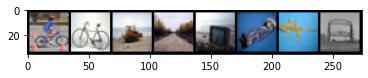

bicycle bicycle tractor road  television otter lizard bridge


In [16]:
# functions to show an image


def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## Define NN
Define the class!

In [3]:
channel_data = testset[0][0].shape[0] # num channels 
data_size = testset[0][0].shape[1]
feature1 = [6,1,2]  # NOTE feature channel num, stide, padding
feature2 = [16,1,2] # NOTE feature channel num, stide, padding
feature3 = [20,3,3]

fc_hid = [100,120]
out_size = len(classes)
k_conv_size = 3 # 3x3 convolution kernel
k_pool = [2,2,2] # pool layer 1, layer 2


def get_output_shape(I, K, P, S, M):
    '''
    compute the output shape of a convolutional layer
    for the computation, you can refer to 
    https://androidkt.com/calculate-output-size-convolutional-pooling-layers-cnn/
    https://stackoverflow.com/questions/53580088/calculate-the-output-size-in-convolution-layer

    I: image size
    K: kernel size
    P: padding size
    S: stride
    M: pooling size
    '''
    return ((I-K+2*P)//S+1)//M

Conv_out1 = get_output_shape(data_size,k_conv_size,feature1[2],feature1[1],k_pool[0])
Conv_out2 = get_output_shape(Conv_out1,k_conv_size,feature2[2],feature2[1],k_pool[1])
Conv_out3 = get_output_shape(Conv_out2,k_conv_size,feature3[2],feature3[1],k_pool[1])

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels= channel_data,out_channels= feature1[0], kernel_size= k_conv_size, stride= feature1[1], padding= feature1[2]), 
            nn.BatchNorm2d(feature1[0]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=k_pool[0])
            )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels= feature1[0],out_channels= feature2[0], kernel_size= k_conv_size, stride= feature2[1], padding= feature2[2]), 
            nn.BatchNorm2d(feature2[0]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=k_pool[1])
            )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels= feature2[0],out_channels= feature3[0], kernel_size= k_conv_size, stride= feature3[1], padding= feature3[2]), 
            nn.BatchNorm2d(feature3[0]),
            nn.GELU(), # better than ReLU
            nn.MaxPool2d(kernel_size=k_pool[2])
            )
        
        self.fc = nn.Sequential(
            nn.Linear(feature3[0] * int(Conv_out3)**2, fc_hid[0]),
            nn.Linear(fc_hid[0], fc_hid[1]),
            nn.Linear(fc_hid[1], out_size),
            )
        

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0),-1)
        out = self.fc(out)
        
        return out


## Predefined CNN as VGG
found in [git](https://github.com/kuangliu/pytorch-cifar/blob/master/models/vgg.py)

Måske bedre?

In [18]:
def get_output_shape(vgg_name,I, K, P, S, M):
    '''
    compute the output shape of a convolutional layer NOTE list
    for the computation, you can refer to 
    https://androidkt.com/calculate-output-size-convolutional-pooling-layers-cnn/
    https://stackoverflow.com/questions/53580088/calculate-the-output-size-in-convolution-layer

    NOTE assumes CONV layer has stride 1 always!

    I: image size
    K: kernel size
    P: padding size
    S: stride
    M: pooling size
    '''
    output_shape =  np.floor((I - K+ 2*P) + 1)
    for x in cfg[vgg_name]:
        if x == 'M':
            output_shape = np.floor((output_shape - K)/S + 1)
            print(output_shape)
        else:
            output_shape = np.floor((output_shape - K+ 2*P) + 1)
            print(output_shape)

        ((I-K+2*P)//S+1)//M
    return output_shape

In [19]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)


def test():
    net = VGG('VGG11')
    x = torch.randn(2,3,32,32)
    y = net(x)
    print(y.size())

#test()

### Define a Loss function and optimizer

In [4]:
model = CNN()
# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= 0.001)

Test

In [5]:
x = torch.randn(2,3,32,32)
print(f"The size of input x: {x.size()}")
# Encoder test
mean, var = model(x)
print(f"The mean shape {mean.size()}, \nthe variance shape {var.size()}")

# Test of gradient for training
#x.requires_grad = True
optimizer.zero_grad()



loss = torch.mean( -0.5 * torch.sum(1+ log_var - mean**2 - log_var.exp(),dim=1),dim = 0)

loss.backward()

print(x.grad_fn)

The size of input x: torch.Size([2, 3, 32, 32])
The mean shape torch.Size([100]), 
the variance shape torch.Size([100])


NameError: name 'log_var' is not defined

Training

In [9]:
epochs = 10

def train(num_epochs, cnn, loaders, plot : bool = False):
    loss_list = []
    cnn.train()
        
    # Train the model
    total_step = len(trainloader)
        
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(trainloader):
            
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            #print(b_x.size())
            b_y = Variable(labels)   # batch y
            output = cnn(b_x)#[0]               
            loss = criterion(output, b_y)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward() 
            print(f"Is there a grad? {b_x.grad_fn}")   
            #print(f"Max grad:{b_x.grad.data.max()} \t min grad:{b_x.grad.data.min()}")
            # apply gradients             
            optimizer.step()                
            
            if (i+1) % total_step//3 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch + 1, epochs, i + 1, total_step, loss.item()))
                if plot:
                    loss_list.append(loss.item())
                
                pass
        pass
    
    if plot:
        xVals = list(range(1, len(loss_list) + 1))
        
        # subplots define number of rows and columns
        fig, ax1 = plt.subplots(1, 1)
        ax1.plot(xVals, loss_list, 'o-')
        fig.suptitle(f"Loss through training.")
        ax1.set_ylabel("Loss over training")
       
    print("Done!")            
    pass

train(epochs, model, trainloader, True)

Is there a grad? None
Epoch [1/10], Step [1/6250], Loss: 4.6561
Is there a grad? None
Epoch [1/10], Step [2/6250], Loss: 4.5851
Is there a grad? None
Is there a grad? None
Is there a grad? None
Is there a grad? None
Is there a grad? None
Is there a grad? None
Is there a grad? None
Is there a grad? None
Is there a grad? None
Is there a grad? None
Is there a grad? None
Is there a grad? None
Is there a grad? None
Is there a grad? None
Is there a grad? None
Is there a grad? None
Is there a grad? None
Is there a grad? None
Is there a grad? None
Is there a grad? None
Is there a grad? None
Is there a grad? None
Is there a grad? None
Is there a grad? None
Is there a grad? None
Is there a grad? None
Is there a grad? None
Is there a grad? None
Is there a grad? None
Is there a grad? None
Is there a grad? None
Is there a grad? None
Is there a grad? None
Is there a grad? None
Is there a grad? None
Is there a grad? None
Is there a grad? None
Is there a grad? None
Is there a grad? None
Is there a gra

KeyboardInterrupt: 

## Test

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: apple is 68.0 %
Accuracy for class: aquarium_fish is 32.0 %
Accuracy for class: baby  is 39.0 %
Accuracy for class: bear  is 2.0 %
Accuracy for class: beaver is 4.0 %
Accuracy for class: bed   is 12.0 %
Accuracy for class: bee   is 17.0 %
Accuracy for class: beetle is 41.0 %
Accuracy for class: bicycle is 30.0 %
Accuracy for class: bottle is 40.0 %
Accuracy for class: bowl  is 19.0 %
Accuracy for class: boy   is 2.0 %
Accuracy for class: bridge is 23.0 %
Accuracy for class: bus   is 30.0 %
Accuracy for class: butterfly is 32.0 %
Accuracy for class: camel is 13.0 %
Accuracy for class: can   is 27.0 %
Accuracy for class: castle is 54.0 %
Accuracy for class: caterpillar is 28.0 %
Accuracy for class: cattle is 21.0 %
Accuracy for class: chair is 50.0 %
Accuracy for class: chimpanzee is 52.0 %
Accuracy for class: clock is 18.0 %
Accuracy for class: cloud is 41.0 %
Accuracy for class: cockroach is 41.0 %
Accuracy for class: couch is 13.0 %
Accuracy for class: crab  is 26.

In [ ]:
def test( model, device, test_loader):

    # Accuracy counter
    correct = 0
    indx = 1

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        #data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        

        final_pred = output.max(1, keepdim=True) # get the index of the max log-probability
        final_pred_index = final_pred[1]
        #numCorrectOnIter = (target.numpy() == final_pred_index)
        #correct += numCorrectOnIter
        #print(type(target == final_pred_index))
        for label, pred in zip(target, final_pred_index):
           
            if label == pred:
                correct += 1
                
        indx += 1
        
    #print(f"Amount of batches in test loader: {indx - 1}")
    print(f"correct {correct}, testloader {len(test_loader)}, batchsize {batch_size}")
    final_acc = (correct/float(len(test_loader)*batch_size))
    #print(correct)
    #print(len(test_loader)*batch_size)
    return final_acc



test(model, DEVICE, testloader)

correct 2776, testloader 1000, batchsize 10


0.2776